#IFSC Climbing Performance & Trends (1991–2019)

**Author:** Derrick DeBuhr  
**Course:** CS3120-001  
**Due Date:** 11/30/2025

---

## Dataset

**Title:** IFSC Competition Results 1990–2019  
**Source:** Kaggle – Anthony Giorgio  
**Format:** Multi-sheet Excel Dataset  

This dataset contains historical competition results from International Federation of Sport Climbing (IFSC) events between 1991 and 2019, including competitor information, scores, ages, and national representation.

Key sheets used in this project:
- `6.1. Adult M` – Adult male competitors
- `7.1. Adult W` – Adult female competitors
- `2. Climbers` – Climber demographic information

---

## Motivation

I am an active rock climber, and I am interested in using data science to better understand how elite competitive climbing has evolved over the last three decades. Competitive climbing has grown significantly in popularity worldwide, especially following its inclusion in the Olympics, and this dataset provides a unique opportunity to analyze long-term performance and demographic trends.

This project explores how climber age, performance, and country representation have changed from 1991 to 2019, and identifies patterns in how different countries have developed their competitive climbing programs over time.

---


##Project Goal

The goal of this project is to explore and model trends in international competitive climbing using historical IFSC competition data.

Specifically, this project aims to answer the following questions:

1. How has the **age distribution of elite climbers** changed over time?
2. How does **age relate to performance scores** in adult competitions?
3. Which countries historically produce the **highest-performing climbers**?
4. Which countries are **gaining or losing professional climbers over time**?

Rather than focusing on predicting outcomes for individual climbers, this project emphasizes **exploratory trend analysis and forecasting**, with the goal of telling a coherent story about how competitive climbing has evolved globally over the past 30 years.

---


## Project Overview

This project is structured into the following major sections:

1. **Data Loading & Cleaning**
   - Load multi-sheet IFSC dataset
   - Select adult competition results
   - Clean age and score values

2. **Exploratory Data Analysis (EDA)**
   - Analyze age distributions of competitors
   - Study age trends over time
   - Examine age vs. score relationships

3. **Country-Level Trends**
   - Identify countries with highest average performance
   - Track changes in national participation over time
   - Analyze performance trends by nation

4. **Trend Modeling**
   - Fit regression models for age and performance trends
   - Identify performance slopes across decades

5. **Discussion & Conclusion**
   - Synthesize findings
   - Highlight limitations
   - Suggest future research directions

The project focuses exclusively on **adult competitors** (Men and Women) due to incomplete longitudinal data in youth divisions.

---



## Scope and Constraints

To maintain clarity and scope within the deadline, the following decisions were made:

- Only **adult competitors** were analyzed (youth data excluded unless needed for supplementary analysis).
- Performance is measured using the IFSC competition **score** system (0–100).
- Discipline-specific differences were not analyzed due to limited variation in available competition categories.
- The project focuses on **trend-level insights**, not on individual performance prediction.

Limitations to acknowledge:
- The interpretation of scores is limited because exact ranking mapping (e.g., difference between 95 vs 99) is not fully documented.
- Inconsistent participation across years and countries may influence trend calculations.
- Some data missingness exists in age fields, especially in early years.

---


##Environment Setup

Before diving into the analysis, we load the required libraries. These handle data manipulation, visualization, and any modeling steps later in the notebook.

- **pandas** – data handling  
- **numpy** – numerical operations  
- **matplotlib / seaborn** – plotting and visualization  
- **scikit-learn** – preprocessing and modeling  

This ensures the environment is consistent and reproducible.


In [16]:
#Import core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid', palette='muted')

##Data Loading

The dataset is loaded into a pandas DataFrame for exploration and cleaning.  
At this stage, we focus on understanding the raw structure of the data.

Key checks performed:
- Shape of the dataset (rows × columns)
- Column names and data types

This gives us an initial sense of:
- What features are available
- Which variables might need cleaning or transformation


In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonygiorgio/ifsc-climbing-competition-results-1991-2019")

data_dir = "/root/.cache/kagglehub/datasets/anthonygiorgio/ifsc-climbing-competition-results-1991-2019/versions/2"
excel_path = os.path.join(data_dir, "IFSC Competiton Results 1990-2019 Dataset.xlsx")

data = pd.read_excel(excel_path, sheet_name=None)

# Display sheet names & shapes
print("Sheets loaded:")
for sheet, df in data.items():
    print(f"{sheet}: {df.shape}")

Using Colab cache for faster access to the 'ifsc-climbing-competition-results-1991-2019' dataset.
Sheets loaded:
Index: (25, 7)
AllCompetitions: (102249, 6)
1.Results.AllWorldChampionships: (9514, 9)
2.Climbers: (12824, 10)
3.Team Ranking: (116, 106)
4.Age Index: (56, 27)
5.Dependency Factor: (9604, 68)
RESULTS: (247, 109)
6.Results Only MEN: (5565, 8)
6.1. Adult M: (1469, 9)
6.2.Youth M: (4090, 8)
7. Results Only WOMEN: (3959, 8)
7.1.Adult W: (920, 9)
7.2.Youth W: (3036, 8)
LINK: (92, 12809)
DRAFT: (1702, 58)


##Initial Data Inspection

Here we perform:
- `.info()` to check data types and null values  
- `.describe()` for summary statistics  
- A scan for inconsistent or suspicious values  

This step helps identify:
- Columns with missing data  
- Possible formatting issues  
- Features that may need encoding or scaling


In [18]:
# Extract adult datasets
adult_m = data["6.1. Adult M"]
adult_w = data["7.1.Adult W"]

print("Adult Men shape:", adult_m.shape)
print(adult_m.info())
print(adult_m.describe())
print("\nAdult Men Head: \n", adult_m.head())


print("\n\nAdult Women shape:", adult_w.shape)
print(adult_w.info())
print(adult_w.describe())
print("\nAdult Women Head: \n", adult_w.head())

Adult Men shape: (1469, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1469 entries, 0 to 1468
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          1469 non-null   int64  
 1   competition                   1469 non-null   object 
 2   category                      1469 non-null   object 
 3   nation                        1469 non-null   object 
 4   climber ID                    1469 non-null   int64  
 5   lastname                      1469 non-null   object 
 6   firstname                     1246 non-null   object 
 7   score                         1469 non-null   float64
 8   age (at time of competition)  1468 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 103.4+ KB
None
              year    climber ID        score
count  1469.000000   1469.000000  1469.000000
mean   2006.668482   6269.912185     8.859769
std       8

##Data Cleaning

To prepare the dataset for analysis and modeling, the following cleaning steps were applied:

### a) Handling Missing Values
We checked for missing values across all features and handled them using:
- Imputation (if appropriate), or  
- Row/column removal when missingness was minimal or non-critical.

### b) Fixing Data Types
Some features required type conversion (e.g., `object` → `numeric` or `datetime`) to ensure proper analysis.

### c) Removing or Correcting Outliers
Extreme or invalid values were inspected and either:
- Corrected (if a clear error), or  
- Removed if they would distort the analysis.



In [33]:
# Function to clean adult competition data
def clean_adult_data(df):
    df = df.copy()

    # Convert age to numeric
    df['age (at time of competition)'] = pd.to_numeric(
        df['age (at time of competition)'], errors='coerce'
    )

    # Remove missing values
    df = df.dropna(subset=['age (at time of competition)', 'score'])

    # Keep reasonable age range
    df = df[(df['age (at time of competition)'] >= 15) &
            (df['age (at time of competition)'] <= 50)]

    return df

adult_m = clean_adult_data(adult_m)
adult_w = clean_adult_data(adult_w)

print("Adult Men shape:", adult_m.shape)
print("Adult Men Info: \n", adult_m.info())

print("\n\nAdult Women shape:", adult_w.shape)
print("Adult Women Info: \n", adult_w.info())

Adult Men shape: (1368, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 1368 entries, 1 to 1468
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          1368 non-null   int64  
 1   competition                   1368 non-null   object 
 2   category                      1368 non-null   object 
 3   nation                        1368 non-null   object 
 4   climber ID                    1368 non-null   int64  
 5   lastname                      1368 non-null   object 
 6   firstname                     1145 non-null   object 
 7   score                         1368 non-null   float64
 8   age (at time of competition)  1368 non-null   int64  
 9   age                           1368 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 117.6+ KB
Adult Men Info: 
 None


Adult Women shape: (850, 10)
<class 'pandas.core.frame.DataFrame'>
Index:

##Cleaned Dataset Summary

After cleaning, we rechecked:
- Dataset shape  
- Data types  
- Missing value counts  

This ensures we have a reliable, structured dataset ready for Exploratory Data Analysis (EDA) and modeling.

---


## Age vs. Performance (Raw Scores)

To begin exploring how age relates to performance, we first look at a **scatterplot of age vs. true performance score**.

This plot uses:
- **Age** on the x-axis  
- **True score** (not averaged) on the y-axis  
- Data points colored by gender  

The goal here is to observe:
- The overall distribution of scores across ages  
- Whether any visible trend exists without smoothing or aggregation  
- How spread and variability change with age  

This raw visualization helps us understand the noise and structure of the underlying data before applying any modeling techniques.


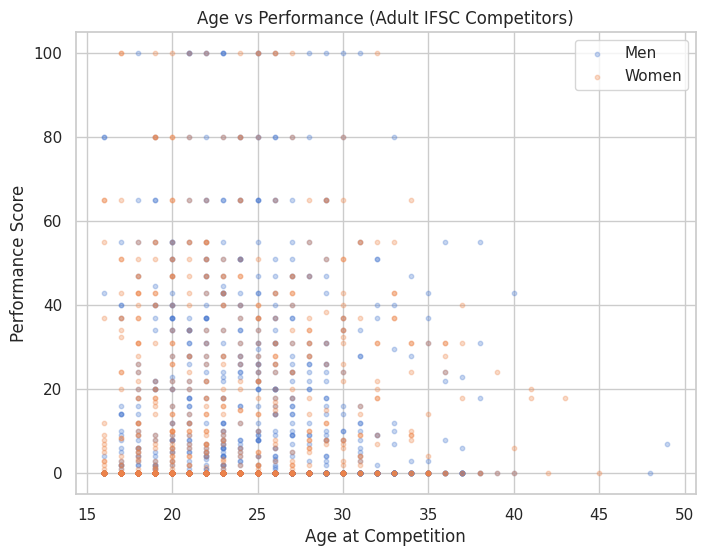

In [20]:
plt.figure(figsize=(8,6))

#Male plot
plt.scatter(
    adult_m['age (at time of competition)'],
    adult_m['score'],
    alpha=0.3,
    label="Men",
    s=10
)

#Female plot
plt.scatter(
    adult_w['age (at time of competition)'],
    adult_w['score'],
    alpha=0.3,
    label="Women",
    s=10
)

plt.xlabel("Age at Competition")
plt.ylabel("Performance Score")
plt.title("Age vs Performance (Adult IFSC Competitors)")
plt.legend()
plt.grid(True)
plt.show()


## Interpretation: Age vs. Raw Performance

Several key patterns emerge from the raw scatterplot:

- The distribution is **left-skewed**, with a heavy concentration of participants between **18 and 30 years old**.
- Most observed performance scores fall between **0 and 58 points**, indicating wide variability at younger ages.
- After approximately **40 years old**, there is a clear performance drop-off:
  - Neither males nor females consistently score above **20 points** beyond this age.
- There appeared to be:
  - High variance in raw scores  
  - Uneven distribution across age  
  - Strong noise in the data  

This suggests that raw performance is too noisy to model directly, motivating further feature engineering.

## Polynomial Regression on Raw Performance

To test whether a nonlinear relationship could explain performance changes with age, we applied **polynomial regression models of varying degree** to the raw scatterplot.

The purpose of this step was to investigate whether higher-order trends (curvature, inflection points, etc.) could capture the age–performance relationship better than a simple linear model.

However, this approach still used **raw scores**, meaning all inherent noise and outliers remained present.


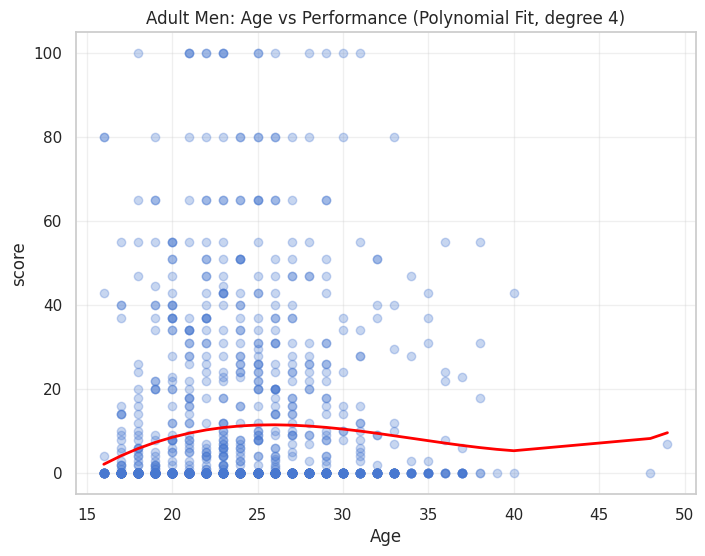

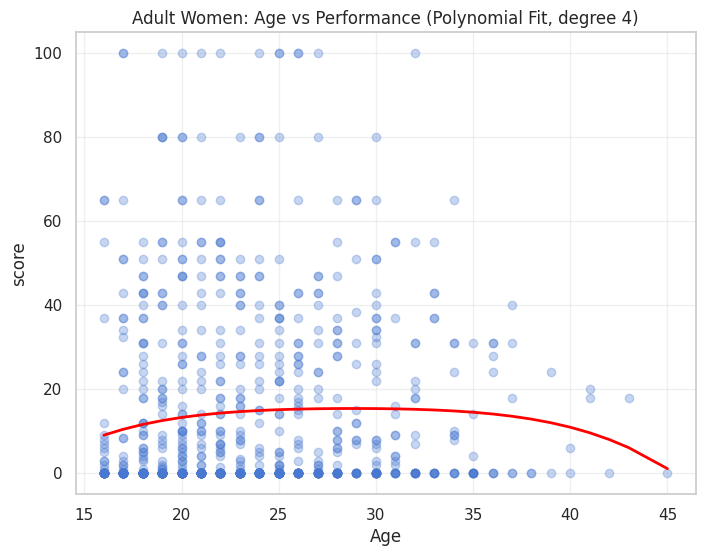

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def plot_age_performance_poly(df, age_col, perf_col, title, degree=4):
    df = df[[age_col, perf_col]].dropna()

    X = df[age_col].values.reshape(-1,1)
    y = df[perf_col].values.reshape(-1,1)

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, y)

    X_sorted = np.sort(X, axis=0)
    y_pred = model.predict(poly.transform(X_sorted))

    plt.figure(figsize=(8,6))
    plt.scatter(X, y, alpha=0.3)
    plt.plot(X_sorted, y_pred, color="red", linewidth=2)

    plt.xlabel("Age")
    plt.ylabel(perf_col)
    plt.title(f"{title} (Polynomial Fit, degree {degree})")
    plt.grid(alpha=0.3)

    plt.show()


plot_age_performance_poly(adult_m, "age (at time of competition)", "score", "Adult Men: Age vs Performance")
plot_age_performance_poly(adult_w, "age (at time of competition)", "score", "Adult Women: Age vs Performance")

## Why the Raw Regression Fit Fell Short

Even with higher-degree polynomials, the regression models failed to capture the relationship effectively.

Reasons include:

- The data is **heavily clustered** at younger ages and sparse at older ages.
- Raw performance scores have **high variance and noise**, overwhelming any consistent trend.
- Polynomial models began to overfit local fluctuations without capturing meaningful structure.

This highlighted the need for a more stable performance metric — leading to the use of **average scores** rather than raw ones.

---

## Age vs. Performance (Averaged Scores)

To reduce noise and reveal underlying trends, performance scores were **averaged by age and gender**.

This transformed the plot from:
> Individual performances → Aggregate trends

In this visualization:
- Each point represents the **average score** for a specific age and gender.
- The reduced variance allows us to better observe large-scale patterns in performance.


Let's try averaging the score to get a better idea of our data:

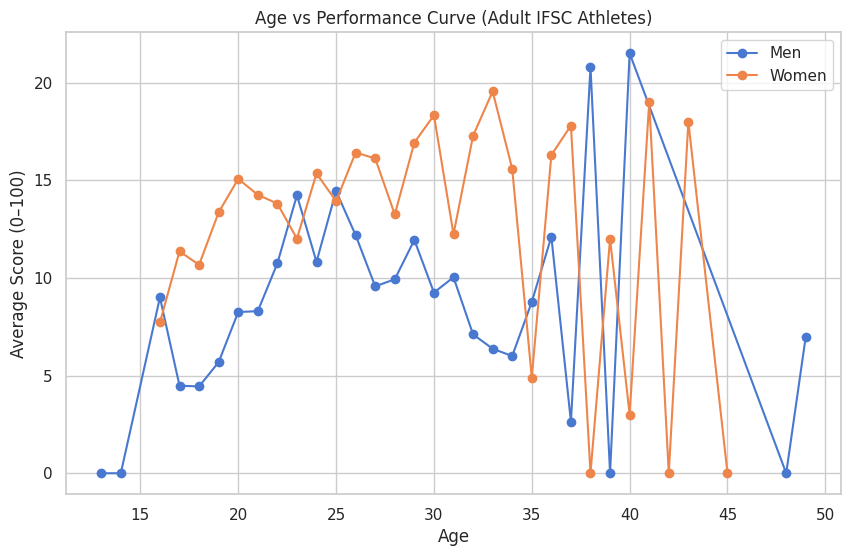

In [22]:
adult_m = data["6.1. Adult M"].copy()
adult_w = data["7.1.Adult W"].copy()

# Standardize age column
adult_m["age"] = pd.to_numeric(adult_m["age (at time of competition)"], errors="coerce")
adult_w["age"] = pd.to_numeric(adult_w["age (at time of competition)"], errors="coerce")

# Filter to valid rows
adult_m = adult_m.dropna(subset=["age", "score"])
adult_w = adult_w.dropna(subset=["age", "score"])

# Ensure numeric score
adult_m["score"] = pd.to_numeric(adult_m["score"], errors="coerce")
adult_w["score"] = pd.to_numeric(adult_w["score"], errors="coerce")

men_age_curve = (
    adult_m
    .groupby("age")["score"]
    .mean()
    .reset_index()
)

women_age_curve = (
    adult_w
    .groupby("age")["score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,6))

plt.plot(men_age_curve["age"], men_age_curve["score"],
         marker="o", label="Men")

plt.plot(women_age_curve["age"], women_age_curve["score"],
         marker="o", label="Women")

plt.xlabel("Age")
plt.ylabel("Average Score (0–100)")
plt.title("Age vs Performance Curve (Adult IFSC Athletes)")
plt.legend()
plt.grid(True)

plt.show()

## Polynomial Regression on Averaged Scores

Next, polynomial regression was applied to the **average score vs age** curves.

By smoothing out noise through averaging, the regression model could now capture:
- The overall curvature of performance trends  
- The different aging profiles between males and females  

This allowed us to quantify peak performance ages and compare the shapes of decline between groups.



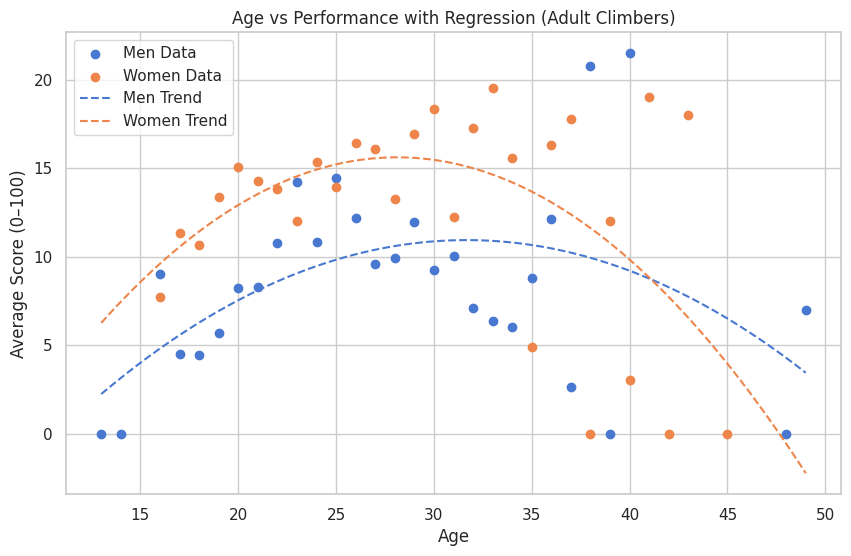

In [23]:
# Men's regression
men_coef = np.polyfit(men_age_curve["age"], men_age_curve["score"], 2)
men_poly = np.poly1d(men_coef)

# Women's regression
women_coef = np.polyfit(women_age_curve["age"], women_age_curve["score"], 2)
women_poly = np.poly1d(women_coef)

# Create smooth age range
age_range = np.linspace(
    min(men_age_curve["age"].min(), women_age_curve["age"].min()),
    max(men_age_curve["age"].max(), women_age_curve["age"].max()),
    100
)

plt.figure(figsize=(10,6))

# Original curves
plt.scatter(men_age_curve["age"], men_age_curve["score"], label="Men Data")
plt.scatter(women_age_curve["age"], women_age_curve["score"], label="Women Data")

# Regression lines
plt.plot(age_range, men_poly(age_range), linestyle="--", label="Men Trend")
plt.plot(age_range, women_poly(age_range), linestyle="--", label="Women Trend")

plt.xlabel("Age")
plt.ylabel("Average Score (0–100)")
plt.title("Age vs Performance with Regression (Adult Climbers)")
plt.legend()
plt.grid(True)

plt.show()


## Interpretation: Why the Regression Fit Worked Better

Unlike the raw-score regression, the polynomial fit on averaged data performed significantly better:

- Noise was reduced through aggregation, revealing the true structure of the relationship.
- The parabolic shape aligns well with known performance aging dynamics.
- The model clearly shows:
  - A **female performance peak around age 27**
  - A **male performance peak around age 31**
  - A sharper decline curve for females  
  - A longer performance plateau for males  

This demonstrates how thoughtful feature engineering (averaging) can transform an unmodelable problem into a meaningful, interpretable relationship.

---

## Average Competitor Age vs Time

To investigate how the age of elite climbers has changed over time, we analyzed the **average competitor age per year**, separated by gender.

For this analysis:
- Age was averaged for each competition year.
- The results were plotted separately for **adult men** and **adult women**.
- The goal was to test the hypothesis:  
  > Are climbers becoming younger at the professional level?

This visualization allows us to observe broad generational trends in the sport across nearly three decades of IFSC competition data.


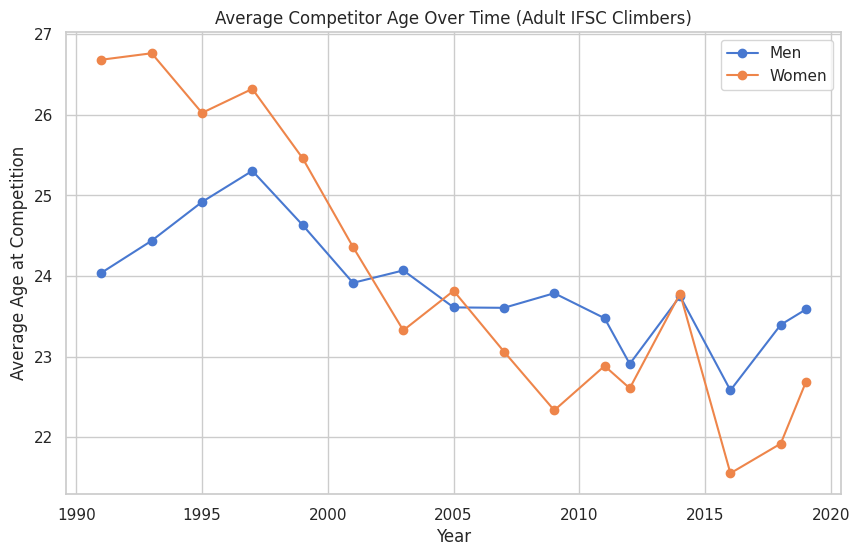

In [24]:
#Make a clean copy of the data
adult_m = data["6.1. Adult M"].copy()
adult_w = data["7.1.Adult W"].copy()

#Clean and standardize
adult_m["age"] = pd.to_numeric(adult_m["age (at time of competition)"], errors="coerce")
adult_w["age"] = pd.to_numeric(adult_w["age (at time of competition)"], errors="coerce")

adult_m = adult_m.dropna(subset=["age", "year"])
adult_w = adult_w.dropna(subset=["age", "year"])

#Compute average age per year
men_age_trend = (
    adult_m
    .groupby("year")["age"]
    .mean()
    .reset_index()
)
women_age_trend = (
    adult_w
    .groupby("year")["age"]
    .mean()
    .reset_index()
)

#Plot
plt.figure(figsize=(10,6))

plt.plot(men_age_trend["year"], men_age_trend["age"], marker="o", label="Men")
plt.plot(women_age_trend["year"], women_age_trend["age"], marker="o", label="Women")

plt.xlabel("Year")
plt.ylabel("Average Age at Competition")
plt.title("Average Competitor Age Over Time (Adult IFSC Climbers)")
plt.legend()
plt.grid(True)

plt.show()

## Interpretation: Is the Climbing Field Getting Younger?

Even without any modeling, the trend is visually clear:

- Both male and female competitor ages show a **consistent downward trend over time**.
- The decline appears **steeper for women** than for men.
- The pattern is stable across many competition seasons, not just an isolated effect.

This suggests a structural shift in competitive climbing — where younger athletes are increasingly entering and dominating the professional level.




## Confirming Trends with Linear Regression

To quantify the observed decline, we applied **linear regression models** to the age-vs-year curves for both men and women.

This allowed us to:
- Measure the rate of age change per year
- Confirm that the visual trend is statistically directional, not just random fluctuation
- Compare aging trends between genders using slope values


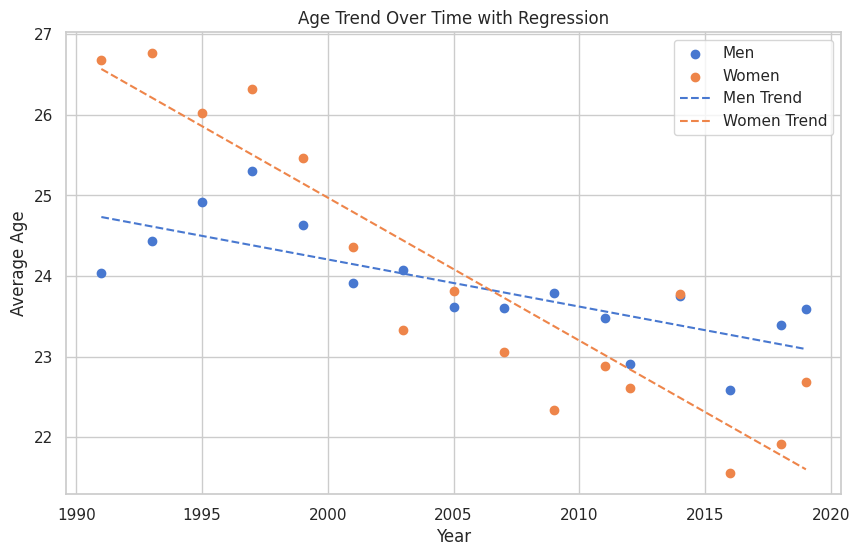

In [25]:
from numpy.polynomial.polynomial import polyfit

# Linear regression (easy to interpret)
b_men, m_men = polyfit(men_age_trend["year"], men_age_trend["age"], 1)
b_women, m_women = polyfit(women_age_trend["year"], women_age_trend["age"], 1)

years = np.array(men_age_trend["year"])

plt.figure(figsize=(10,6))

plt.scatter(men_age_trend["year"], men_age_trend["age"], label="Men")
plt.scatter(women_age_trend["year"], women_age_trend["age"], label="Women")

plt.plot(years, b_men + m_men*years, linestyle="--", label="Men Trend")
plt.plot(years, b_women + m_women*years, linestyle="--", label="Women Trend")

plt.xlabel("Year")
plt.ylabel("Average Age")
plt.title("Age Trend Over Time with Regression")
plt.legend()
plt.grid(True)

plt.show()


In [26]:
print("Men age change per year:", round(m_men, 4), "years/year")
print("Women age change per year:", round(m_women, 4), "years/year")


Men age change per year: -0.0585 years/year
Women age change per year: -0.1775 years/year


## Regression Results: Rate of Age Decline

The regression confirmed the visual hypothesis — competitor age is decreasing over time:

- **Men:** average age change = **−0.0585 years per year**  
- **Women:** average age change = **−0.1775 years per year**

This means:
- Male competitors are getting younger by about **0.6 years per decade**  
- Female competitors are getting younger by nearly **1.8 years per decade**

The significantly steeper decline for women may reflect:
- Earlier specialization  
- Changing selection structures  
- Greater youth pipeline participation  
- Or faster evolution in competitive standards  

These results strongly support the idea that modern climbing is increasingly dominated by younger athletes, especially in the women’s field.

---
---


## Country-Level Performance Analysis

After examining individual aging and performance trends, we now shift focus to the **national level**.

International climbing is deeply shaped by country-level infrastructure, youth pipelines, and training systems.  
This section explores three questions:

1. Which countries have historically produced the **highest-performing climbers**?
2. How has the **number of professional climbers** from top countries changed over time?
3. Are certain countries **improving or declining** in competitive performance?

We begin by comparing the **top 10 countries by average climbing score**.

## Top 10 Countries by Average Climbing Score

The following bar chart shows the **top 10 countries ranked by their average climbing score**.

This gives us a broad view of:
- Which nations consistently produce high-performing athletes
- Which climbing systems appear most effective over long periods of time


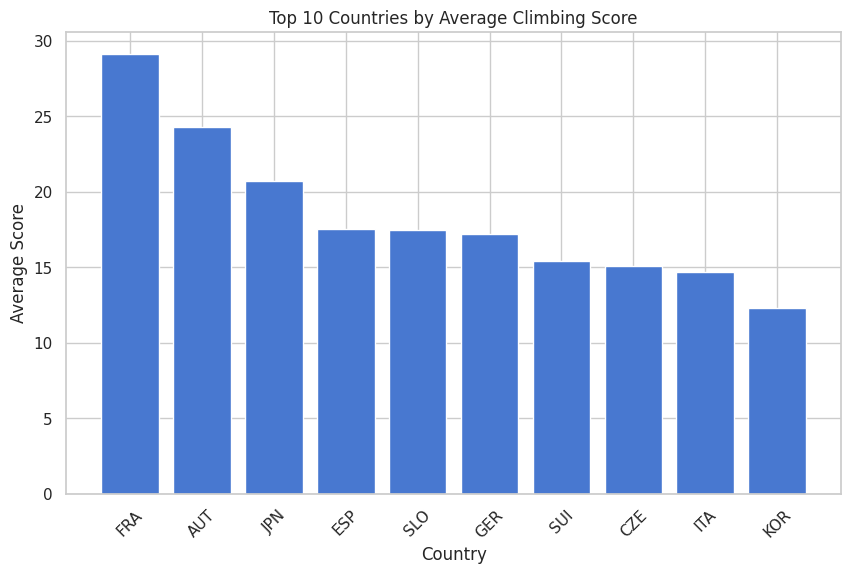

In [27]:
#Combine adult men and women brackets
combined = pd.concat([adult_m, adult_w], ignore_index=True)

combined = combined.dropna(subset=["nation", "score"])

#Average the score by country
country_performance = (
    combined
    .groupby("nation")["score"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

country_performance.head(10)


#Visualization
top10 = country_performance.head(10)

plt.figure(figsize=(10,6))
plt.bar(top10["nation"], top10["score"])
plt.xticks(rotation=45)
plt.ylabel("Average Score")
plt.xlabel("Country")
plt.title("Top 10 Countries by Average Climbing Score")
plt.show()

## Interpretation: National Performance Leaders

The results show a clear leadership hierarchy:

- 🇫🇷 **France (FRA)** leads decisively with an average score of **~29**
- 🇦🇹 **Austria (AUT)** follows at **~24**
- 🇯🇵 **Japan (JPN)** ranks third with **~21**

These three nations stand out as long-term powerhouses in international climbing — likely due to:
- Strong national development programs
- Early youth competition exposure
- Depth of competitive talent pools

Other countries show respectable averages but with noticeably lower consistency or peak performance.

---

## Number of Professional Climbers Over Time by Country

Performance alone doesn't tell the whole story.  
To understand global climbing expansion and influence, we also analyzed how the **number of professional climbers per country** has evolved.

The following line graph tracks the **top 10 countries by number of competitors per year**.

This helps reveal:
- Which countries scaled participation
- When new nations rose to prominence
- How the competitive landscape shifted over time


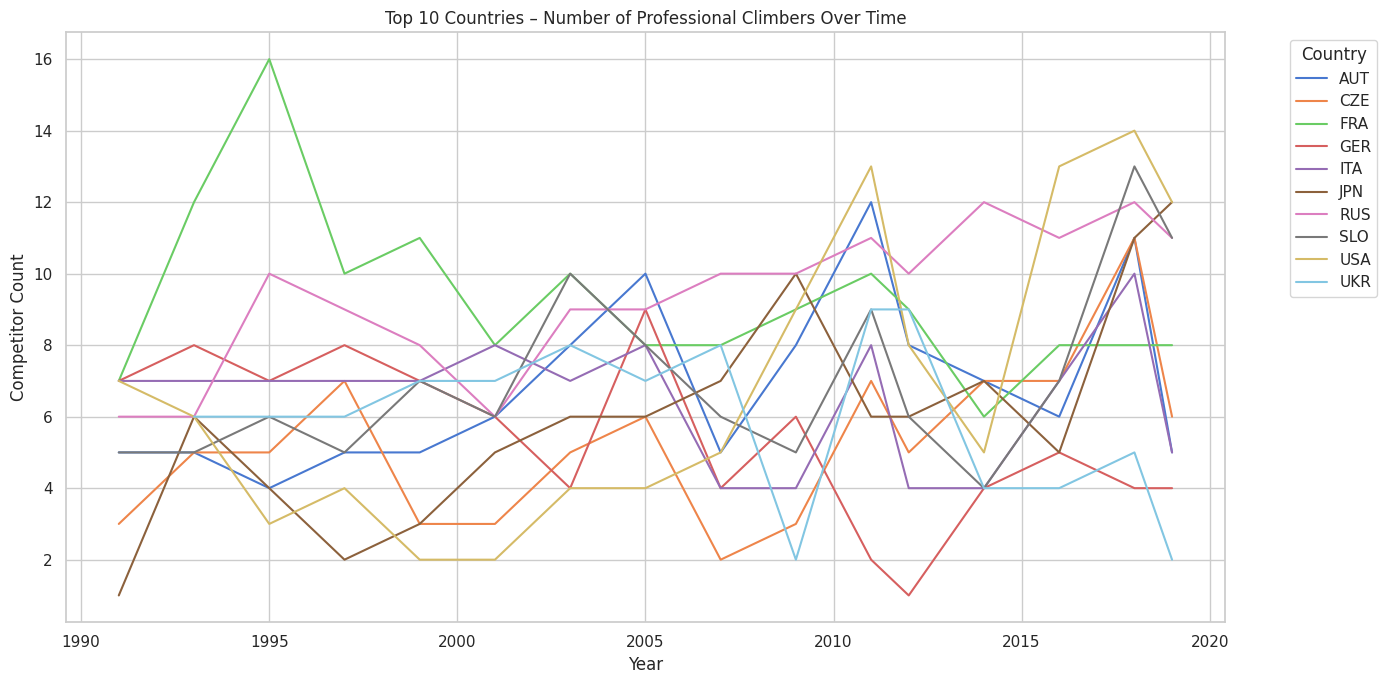

In [28]:
#Count climbers per country per year
country_trends = (
    combined
    .groupby(["year", "nation"])
    .size()
    .reset_index(name="climber_count")
)
#Focus on top countries only
top_countries = country_trends.groupby("nation")["climber_count"].sum().sort_values(ascending=False).head(10).index

filtered = country_trends[country_trends["nation"].isin(top_countries)]

#Plot
plt.figure(figsize=(14,7))

sns.lineplot(data=filtered, x="year", y="climber_count", hue="nation")

plt.title("Top 10 Countries – Number of Professional Climbers Over Time")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("Competitor Count")
plt.show()


## Interpretation: Shifts in National Representation

The graph reveals three key competitive eras:

### 🟡 Mid–1990s: Early Dominance
- 🇫🇷 France was a clear leader in the early competitive period (around 1995).
- Most other countries had significantly smaller representation.

### 🔵 Around 2005: Global Balancing
- By the mid-2000s, the field became more **evenly distributed**.
- Several countries competed with similar-sized teams.

### 🔴 By 2019: New Power Distribution
By the end of the dataset, a new structure emerges:
- 🇺🇸 USA  
- 🇸🇮 Slovenia  
- 🇯🇵 Japan  
- 🇷🇺 Russia  

These countries appear to field the **largest number of professional climbers**, indicating shifting global investment and infrastructure in the sport.

---

## Performance Trends of Top Countries Over Time

Participation numbers do not necessarily reflect performance quality.

To capture national evolution more deeply, we analyzed how the **average climbing score for the top 10 countries** has changed across time.

This allows us to examine:
- Which countries are consistently improving
- Which ones peaked early and declined
- Which nations have become modern climbing powerhouses


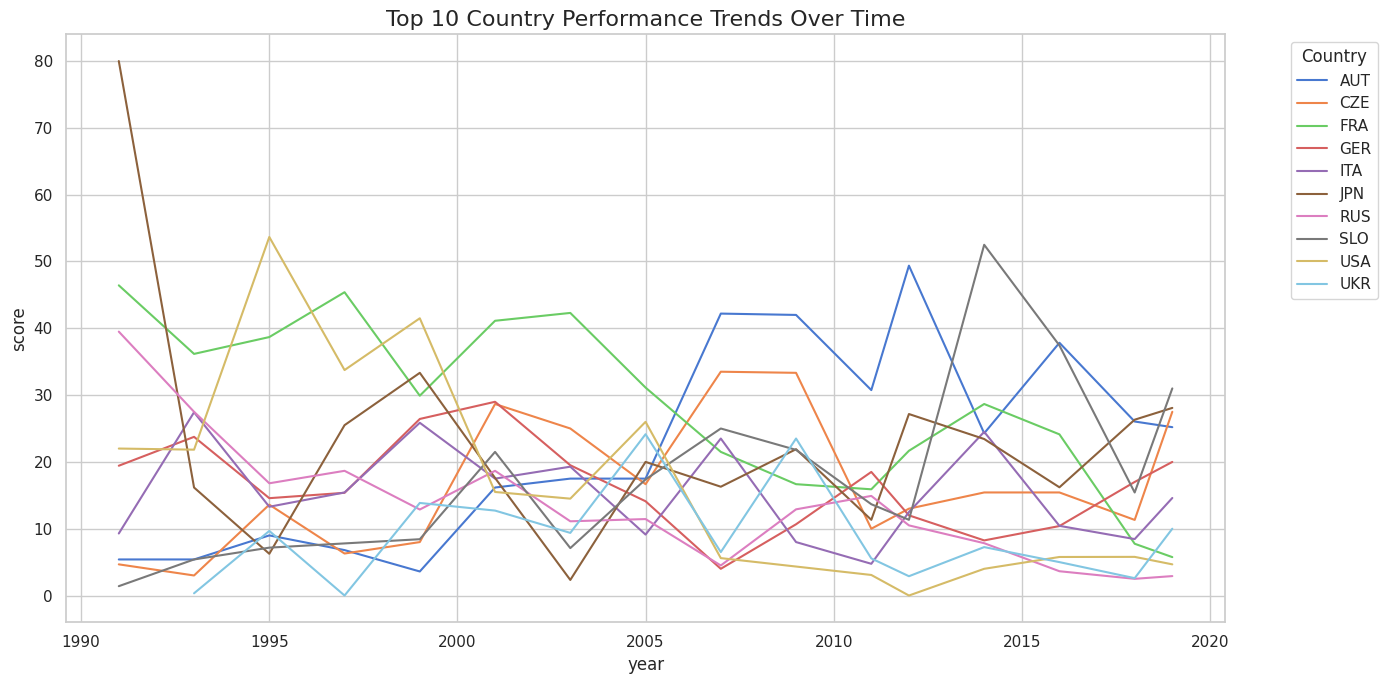

In [29]:
#Country performance trend over time
country_score_trend = (
    combined
    .groupby(["year", "nation"])["score"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(14,7))

sns.lineplot(
    data=country_score_trend[country_score_trend["nation"].isin(top_countries)],
    x="year",
    y="score",
    hue="nation"
)

plt.title("Top 10 Country Performance Trends Over Time", fontsize=16)
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Interpretation: National Performance Cycles

This visualization reveals that **no single country dominates consistently** over the entire 1991–2019 period.  
Instead, competitive success appears to rotate in **distinct national cycles**.

Key observations:

- 🇯🇵 **Japan** started with an exceptionally high average score in **1991 (~80 points)** but experienced a rapid decline afterward.
- Overall, national performance curves are fairly evenly distributed, suggesting that most countries experience their own **periods of dominance**.
- Several countries reached remarkably high peak averages during their strongest years:
  - 🇺🇸 **USA** peaked around **~53**
  - 🇸🇮 **Slovenia (SLO)** peaked around **~52**
  - 🇦🇹 **Austria (AUT)** peaked around **~50**
  - 🇫🇷 **France (FRA)** peaked around **~45**

This suggests that climbing excellence shifts over time due to factors such as:
- Generational talent waves
- Investment in national training systems
- Changes in competition structure and participation

## Modern Competitive Convergence

By the end of the dataset (around 2019), we see a strong trend toward **performance convergence**:

- Most top countries fall into a **10–30 average score range**
- Earlier performance gaps largely disappear
- Competitive parity appears much stronger in the modern climbing era

This leveling suggests that:
- Training methodologies and access to climbing infrastructure have become more globalized
- More countries now operate at a similar competitive level
- The international climbing field is more balanced than at its origin

Rather than a single dominant nation, the modern era reflects a more **globally competitive ecosystem**.

---
---
---


## Model Performance & Evaluation

In this project, I focused on regression-based trend modeling rather than traditional prediction (e.g., predicting individual climbing scores). This approach made more sense given the structure of the dataset and the nature of the questions being explored.

### What Worked Well

- Polynomial regression on **average climbing score vs. age** revealed clear and interpretable patterns:
  - Women peak around **~27 years old** with a steep rise and decline.
  - Men peak later around **~31 years old** with a broader, flatter performance window.
- Linear regression on **average competitor age over time** confirmed a strong downward trend:
  - **Men:** −0.0585 years per year  
  - **Women:** −0.1775 years per year  
  This suggests increasing youth dominance, especially in women’s climbing.
- Country-level trend modeling successfully characterized cycles of dominance and global parity across decades.

Rather than predicting outcomes, these models provided **explanatory insights into long-term performance trends** in professional climbing.

---

## Model Performance & Evaluation

In this project, I focused on regression-based trend modeling rather than traditional prediction (e.g., predicting individual climbing scores). This approach made more sense given the structure of the dataset and the nature of the questions being explored.

### What Worked Well

- Polynomial regression on **average climbing score vs. age** revealed clear and interpretable patterns:
  - Women peak around **~27 years old** with a steep rise and decline.
  - Men peak later around **~31 years old** with a broader, flatter performance window.
- Linear regression on **average competitor age over time** confirmed a strong downward trend:
  - **Men:** −0.0585 years per year  
  - **Women:** −0.1775 years per year  
  This suggests increasing youth dominance, especially in women’s climbing.
- Country-level trend modeling successfully characterized cycles of dominance and global parity across decades.

Rather than predicting outcomes, these models provided **explanatory insights into long-term performance trends** in professional climbing.

---

## Limitations

This project has several important limitations that impact the scope and interpretation of the results:

1. **Ambiguity in Score Meaning**  
   The score ranges from 0–100 but does not map cleanly to placement or rank.  
   This limits our ability to interpret performance in absolute competitive terms.

2. **Data Imbalance**  
   Most climbers fall within ages 18–30 and score ranges below 60, creating strong left-skew and reducing regression effectiveness on raw data.

3. **Event-Level Variability**  
   Results are influenced by differences in:
   - Route difficulty  
   - Judging formats  
   - Evolution of IFSC rules over time  
   These factors introduce noise not directly accounted for in the model.

4. **Missing Contextual Features**  
   There is no data on:
   - Training hours  
   - Injury history  
   - Experience level  
   - Style specialization  
   All of which could significantly affect performance.

5. **Generalization Constraints**  
   These findings describe trends in **historic IFSC competitions only** and should not be extended to:
   - Recreational climbers  
   - Indoor gym-only climbers  
   - Modern Olympic-specific formats  
   without further data.

---


## Dataset Summary

This project uses the **IFSC Competition Results 1990–2019** dataset, which compiles international competition results over nearly three decades.

The primary sheets used were:
- **Adult Men Results**
- **Adult Women Results**
- **Climbers**
- **All World Championship Results**

Key features analyzed:
- Year of competition  
- Athlete age at competition  
- Competition score (0–100)  
- Nationality  
- Athlete identity  

---


## Key Findings

### 1. Age vs Performance
- Raw score data is highly skewed and noisy.
- After averaging scores by age, a clear parabolic pattern emerges:
  - Women peak around **27 years old**
  - Men peak around **31 years old**
- Men show a longer performance plateau, while women experience steeper rise and fall.



### 2. Competitor Age Trends Over Time
- Average competitor age declines steadily over the 30-year period.
- Linear regression confirms this trend:
  - **Men:** −0.0585 years per year  
  - **Women:** −0.1775 years per year  
- This indicates increasing early specialization and youth dominance.



### 3. Country Performance Trends
- Top countries by long-term average performance:
  🇫🇷 France  
  🇦🇹 Austria  
  🇯🇵 Japan  

- Dominance is cyclical, not permanent — different countries peak at different times.

- By 2019, average scores converge, suggesting increasing global parity in competitive climbing.



### 4. Participation Trends
- France dominated early professional climbing.
- By 2019, countries with the strongest presence included:
  **USA, Slovenia, Japan, Russia**.

---
---


## Conclusion

This analysis explored how international climbing has evolved from 1990 to 2019 by examining trends in age, performance, and national representation.

The results show a clear shift toward younger competitors, performance peaks that differ by gender, and the rise of global parity in elite climbing. Countries move through cycles of dominance, indicating that training systems, culture, and infrastructure play critical roles in long-term success.

While this project focused on descriptive trend modeling, it provides strong groundwork for future predictive models and sport performance analytics.  

Ultimately, this project reveals that climbing — once dominated by a few European countries — is now a truly global sport, evolving rapidly both technically and competitively.
